# Probabilistic label spreading

Here, we set up the experiment, i.e. we specify for which hyperparameters the prob. label spreading should be conducted and run the experiment.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
from tqdm import tqdm

from scripts.plot import *
from scripts.baseline_prob_label_spreading import *
from scripts.probabilistic_label_spreading import prob_label_spreading
import time
start_time = time.time()

plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)

In [16]:
dataset_name = "CIFAR10-H" # "EMNIST", "TinyImageNet"
path_to_dataset = "data/prob_data/"+ dataset_name + "/" + dataset_name + ".pkl"

df = pd.read_pickle(path_to_dataset)

classes = list(set(df["label"]))

len(df)

10000

# 2 graph-based probabilistic label spreading using multigrid solver

## 2.1 Run the algorithm

In [17]:
# run the algorithm once
k = 20
n_data = "all"
data_space = "CLIP_UMAP_20"
prob_label_column = "prob_label" #  
alpha = 0.999
n_samples = 10

results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples)

In [18]:
results.head()

,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
0,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.999,10,20,0.277266,0.3841,4.601223,0.121517,0.591302,0.514638,configs/FGMRES.json


### 2.1.1 Train and test data split

In [19]:
train_split = np.random.choice(df.index, size = int(0.8*len(df)), replace=False)

results, processed_data = prob_label_spreading(dataset_name, df.copy(), data_space, prob_label_column, n_data, k, alpha, n_samples, train_split = train_split)

In [20]:
train_mask = df.index.isin(train_split)  # Boolean mask for training data
test_mask = ~train_mask  # Complement mask for test data

train_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[train_mask, "p_hat"].to_list()), np.array(processed_data.loc[train_mask, prob_label_column].to_list()))
train_acc = len(processed_data.loc[train_mask].query("most_probable_class == prediction"))/len(processed_data.loc[train_mask])

test_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[test_mask, "p_hat"].to_list()), np.array(processed_data.loc[test_mask, prob_label_column].to_list()))
test_acc = len(processed_data.loc[test_mask].query("most_probable_class == prediction"))/len(processed_data.loc[test_mask])

print("RMSE on training data: %.4f"%train_rmse, " RMSE on test data: %.4f"%test_rmse)
print("Accuracy on training data: %.4f"%train_acc, " Accuracy on test data: %.4f"%test_acc)

RMSE on training data: 0.2381  RMSE on test data: 0.2389
Accuracy on training data: 0.5429  Accuracy on test data: 0.5400


In [21]:
import torch
from torch.nn.functional import kl_div 

y_true = np.array(processed_data.loc[test_mask, prob_label_column].to_list())
y_hat = np.array(processed_data.loc[test_mask, "p_hat"].to_list())

print("KL Div Testdata: ", kl_div(torch.tensor(y_hat).log(), torch.tensor(y_true), reduction = "batchmean").item())

y_true = np.array(processed_data.loc[train_mask, prob_label_column].to_list())
y_hat = np.array(processed_data.loc[train_mask, "p_hat"].to_list())

print("KL Div Training data: ", kl_div(torch.tensor(y_hat).log(), torch.tensor(y_true), reduction = "batchmean").item())


KL Div Testdata:  3.2722715908706226
KL Div Training data:  3.236205779444595


In [22]:
C = 10

n = 50 # data points 

for C in [10, 100, 1000]:
    y_hat = np.ones((n, C)) * (1/C)
    y_true = np.zeros((n, C))
    y_true[:, 0] = 1

    print("KL Div for C = %d:"%C, kl_div(torch.tensor(y_hat).log(), torch.tensor(y_true), reduction = "batchmean").item(), ", log (C): ", np.log(C))


KL Div for C = 10: 2.3025850929940455 , log (C):  2.3025850929940455
KL Div for C = 100: 4.605170185988092 , log (C):  4.605170185988091
KL Div for C = 1000: 6.907755278982137 , log (C):  6.907755278982137


## 2.2. Hyperparameter Analysis 

It is best to use the experiment pipeline for this, that's why here only an exemplary set of hyperparameters is considered.

In [23]:
n_data = "all"
data_space = "CLIP_UMAP_20"
prob_label_column = "prob_label"

k_list = [5, 20]
alphas = [0.0, 0.5, 0.9, 0.99]
sample_sizes = [10, 100, 1000]


results = pd.DataFrame()
for k in k_list:
    for alpha in alphas:
        for n_samples in sample_sizes:
            result, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples)
            results = pd.concat([results, result], ignore_index = True) # extend the results

In [24]:
results.head()

,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
0,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.0,10,5,0.287054,0.1011,NaN,0.172832,0.853689,0.147071,configs/FGMRES.json
1,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.0,100,5,0.285831,0.1088,NaN,0.171388,0.846571,0.134595,configs/FGMRES.json
2,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.0,1000,5,0.274645,0.1810,NaN,0.158091,0.780769,0.157939,configs/FGMRES.json
3,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,5,0.277020,0.6170,1.999240,0.163239,0.805885,0.382546,configs/FGMRES.json
4,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,100,5,0.224352,0.8011,1.371007,0.107595,0.529419,0.648292,configs/FGMRES.json


## 2.3 Increase dataset size

In [25]:
k = 20
data_space = "CLIP_UMAP_20"

multiple_runs = 10

runtimes = []
accuracies = []

data_sizes = [30, 50, 75, 100, 200, 350, 500, 750, 1000, 2500, 10000, len(df)]

alphas = [0.5, 0.99]
sample_sizes = [100, 500]

avg_feedback = []

results = pd.DataFrame()
for n_samples in sample_sizes:
    for alpha in alphas:
        for n_data in data_sizes:
            for _ in range(multiple_runs):
                while True:
                    try:
                        result, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples)
                        results = pd.concat([results, result], ignore_index = True) # extend the results
                        avg_feedback.append(processed_data["trials"].mean())
                        break
                    except ValueError as e:
                        print(f"Resampling data as not classes are present in the dataset, error: {e}")

results["avg_feedback"] = avg_feedback

Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (9!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (9!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (8!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (8!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (8!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (9!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (9!=10)
Resampling data as not classes are present in the dataset, error: y_true and y_pred have different number of output (9!=10)
Resampli

### 2.3.1 Runtime of the algorithm

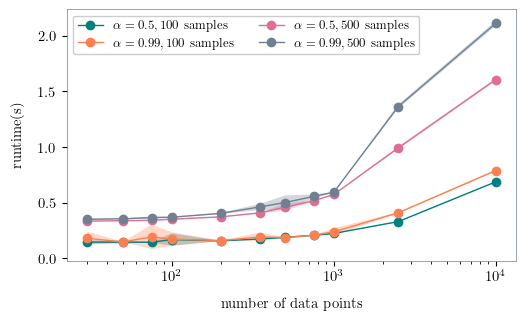

In [26]:
for n_samples in sample_sizes:
    for alpha in alphas:
        X = results["n_data"].unique()
        Y = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["runtime"].mean() for x in X])
        Y_std = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["runtime"].std() for x in X])
        plt.plot(X, Y, marker = "o", label = rf"$\alpha = {alpha}, {n_samples}$ samples")
        plt.fill_between(X, Y-Y_std, Y+Y_std, alpha = 0.3)
        
plt.xscale("log")
plt.xlabel("number of data points")
plt.ylabel("runtime(s)")
plt.legend(ncol = 2)
plt.savefig(f"plots/runtime_depending_on_n_data_on_{dataset_name}.png")
plt.show()

### 2.3.2 Performance of the algorithm

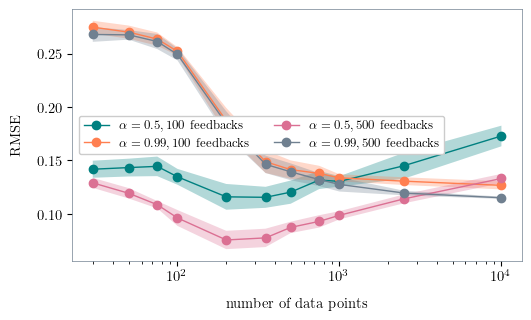

In [27]:
for n_samples in sample_sizes:
    for alpha in [0.5, 0.99]: # alphas
        X = results["n_data"].unique()
        Y = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["RMSE"].mean() for x in X])
        Y_std = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["RMSE"].std() for x in X])
        plt.plot(X, Y, marker = "o", label = rf"$\alpha = {alpha}, {n_samples}$ feedbacks")
        plt.fill_between(X, Y-Y_std, Y+Y_std, alpha = 0.3)
        
plt.xscale("log")
plt.xlabel("number of data points")
plt.ylabel("RMSE")
plt.legend(ncol = 2)
plt.savefig(f"plots/performance_depending_on_n_data_on_{dataset_name}.png")
plt.show()

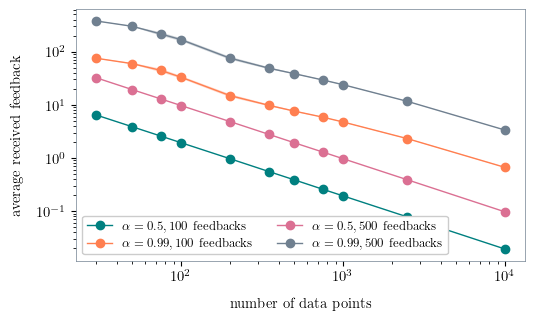

In [28]:
for n_samples in sample_sizes:
    for alpha in [0.5, 0.99]: # alphas
        X = results["n_data"].unique()
        Y = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["avg_feedback"].mean() for x in X])
        Y_std = np.array([results.query(f"n_samples == {n_samples} and alpha == {alpha} and n_data == {x}")["avg_feedback"].std() for x in X])
        plt.plot(X, Y, marker = "o", label = rf"$\alpha = {alpha}, {n_samples}$ feedbacks")
        plt.fill_between(X, Y-Y_std, Y+Y_std, alpha = 0.3)
        
plt.xscale("log")
plt.xlabel("number of data points")
plt.ylabel("average received feedback")
plt.legend(ncol = 2)
plt.yscale("log")
plt.savefig(f"plots/received_feeback_on_n_data_on_{dataset_name}.png")
plt.show()

## 2.4 Average Feedback Received based on spreading intensity

In [29]:
# run the algorithm once
k = 20
n_data = "all"
data_space = "CLIP_UMAP_20"
prob_label_column = "prob_label" #  
n_samples = 1000

alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
multiple_runs = 10
avg_feedback = []

results = pd.DataFrame()
for alpha in alphas:
    print("alpha: ", alpha)
    for _ in range(multiple_runs):
        result, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples)
        results = pd.concat([results, result], ignore_index = True) # extend the results
        avg_feedback.append(processed_data["trials"].mean())

results["avg_feedback"] = avg_feedback

alpha:  0.01
alpha:  0.05
alpha:  0.1
alpha:  0.25
alpha:  0.5
alpha:  0.75
alpha:  0.9
alpha:  0.99
alpha:  0.999


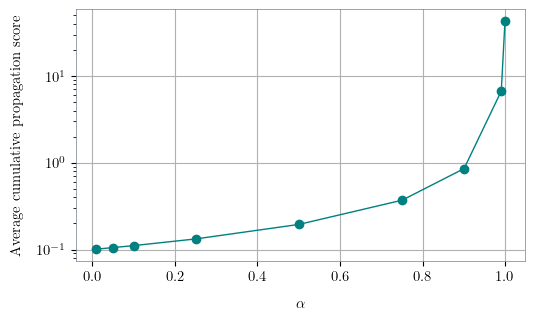

In [30]:
X = alphas
Y = np.array([results.query(f"alpha == {alpha}")["avg_feedback"].mean() for alpha in X])
Y_std = np.array([results.query(f"alpha == {alpha}")["avg_feedback"].std() for alpha in X])

fig = plt.figure()
ax = plt.gca()
ax.plot(X, Y, marker = "o")
ax.fill_between(X, Y-Y_std, Y+Y_std, alpha = 0.3)
plt.yscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average cumulative propagation score")
plt.grid()
plt.savefig(f"plots/average_feedback_depending_on_alpha_on_{dataset_name}.png")

Text(0, 0.5, 'Average received feedback')

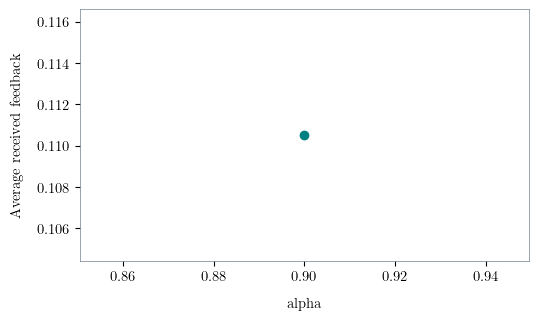

In [44]:
X = alphas
Y = np.array([results.query(f"alpha == {alpha}")["RMSE"].mean() for alpha in X])
Y_std = np.array([results.query(f"alpha == {alpha}")["RMSE"].std() for alpha in X])
plt.plot(X, Y, marker = "o")

plt.fill_between(X, Y-Y_std, Y+Y_std, alpha = 0.3)

plt.xlabel("alpha")
plt.ylabel("Average received feedback")
plt.show()


# 3 Restriction to a subset of datapoints for which feedbacks are assigned

In [32]:
n_samples = 1000 #  10% budget

alpha_ticker = []
proportion_ticker = []
rmse_ticker = []
for alpha in [0.1, 0.5, 0.9, 0.99]:
    print(f"Running for alpha = {alpha}")
    for proportion in [0.01, 0.05, 0.1, 0.25, 0.5, 1.0]:
        train_split = np.random.choice(df.index, size = int(proportion*len(df)), replace=False)
        results, processed_data = prob_label_spreading(dataset_name, df.copy(), data_space, prob_label_column, n_data, k, alpha, n_samples, train_split = train_split)
        rmse_ticker.append(results["RMSE"].iloc[0])
        alpha_ticker.append(alpha)
        proportion_ticker.append(proportion)

results = pd.DataFrame({"alpha": alpha_ticker, "proportion": proportion_ticker, "RMSE": rmse_ticker})


Running for alpha = 0.1
Running for alpha = 0.5
Running for alpha = 0.9
Running for alpha = 0.99


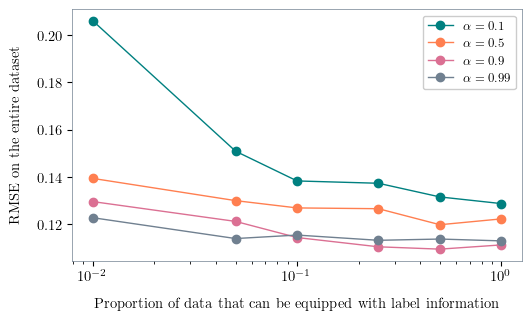

In [33]:
fig = plt.figure()
ax = plt.gca()
for alpha in [0.1, 0.5, 0.9, 0.99]:
    X = results.query(f"alpha == {alpha}")["proportion"]
    Y = results.query(f"alpha == {alpha}")["RMSE"]
    ax.plot(X, Y, marker = "o", label = rf"$\alpha = {alpha}$")
    
plt.xscale("log")
plt.legend()
plt.xlabel("Proportion of data that can be equipped with label information")
plt.ylabel("RMSE on the entire dataset")

plt.savefig("plots/RMSE_subdata_labels_on_CIFAR10-H.png")
plt.show()

# 4 Ablation Studies

## 4.1 Vary the tolerance of the multigrid solver

In [34]:
from scripts.probabilistic_label_spreading_solver_analysis import prob_label_spreading

# fix all other parameters
k = 20
n_data = "all"
data_space = "CLIP_UMAP_20"
alpha = 0.9
budget = 0.1

dataset_name = "CIFAR10-H" # "TinyImageNet" # 
prob_label_column = "prob_label" #   "prob_label_effnetb0" # 

# dataset_name = "ANIMALS10" # "EMNIST", "TinyImageNet"
# prob_label_column = "prob_label_effnetb0" #  "prob_label_effnetb0" # 


path_to_dataset = "data/prob_data/"+ dataset_name + "/" + dataset_name + ".pkl"
df = pd.read_pickle(path_to_dataset)
classes = list(set(df["label"]))
n_samples = int(budget * len(df))

In [35]:
# set the tolerance for the FGMRES solver
tol = 1e-5
config = json.load(open("configs/FGMRES.json"))
config["solver"]["tolerance"] = tol # set tolerance
config["solver"]["max_iters"] = 100000 # allow for a very large number of iterations
json.dump(config, open(f"configs/different_tolerances/FGMRES_tol_{tol}.json", "w")) # store the updated config

results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples, config = f"configs/different_tolerances/FGMRES_tol_{tol}.json")
results.head()

,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,runtime,config
0,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.9,1000,20,0.11069,0.9005,0.421726,3.392507,configs/different_tolerances/FGMRES_tol_1e-05....


In [36]:
tolerances = [1e-8, 1e-1, 0.25, 0.5]#[1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # 1e-12 should be the smallest tolerance we ask for due to machine precision (float64)
multiple_runs = 2 # 10
runtimes = []
runtimes_std = []
rmses = []
rmses_std = []
for tol in tqdm(tolerances, desc = "Processing tolerances"):
    tmp_runtimes = []
    tmp_rmses = []
    for _ in tqdm(range(multiple_runs), desc = "Repetitions", leave = False):
        config = json.load(open("configs/FGMRES.json"))
        config["solver"]["tolerance"] = tol # set tolerance
        config["solver"]["max_iters"] = 10000000 # allow for a very large number of iterations
        json.dump(config, open(f"configs/different_tolerances/FGMRES_tol_{tol}.json", "w"))
        
        start_time = time.time()
        results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples, config = f"configs/different_tolerances/FGMRES_tol_{tol}.json")
        tmp_runtimes.append(time.time() - start_time)
        tmp_rmses.append(results["RMSE"].iloc[0])
    runtimes.append(np.mean(tmp_runtimes))
    rmses.append(np.mean(tmp_rmses))
    runtimes_std.append(np.std(tmp_runtimes, ddof = 1))
    rmses_std.append(np.std(tmp_rmses, ddof = 1))

Processing tolerances: 100%|██████████| 4/4 [00:20<00:00,  5.05s/it]


In [37]:
df = pd.DataFrame({"tolerance": tolerances, "runtime": runtimes, "RMSE": rmses, "runtime_std": runtimes_std, "RMSE_std": rmses_std})
#df.to_csv(f"results/tolerance_analysis_{dataset_name}.csv", index = False)
df.head()

,tolerance,runtime,RMSE,runtime_std,RMSE_std
0,1.000000e-08,4.666239,0.109100,0.007205,0.002115
1,1.000000e-01,1.823797,0.109374,0.012630,0.000214
2,2.500000e-01,1.796938,0.109168,0.013037,0.001112
3,5.000000e-01,1.794058,0.109786,0.002532,0.001028


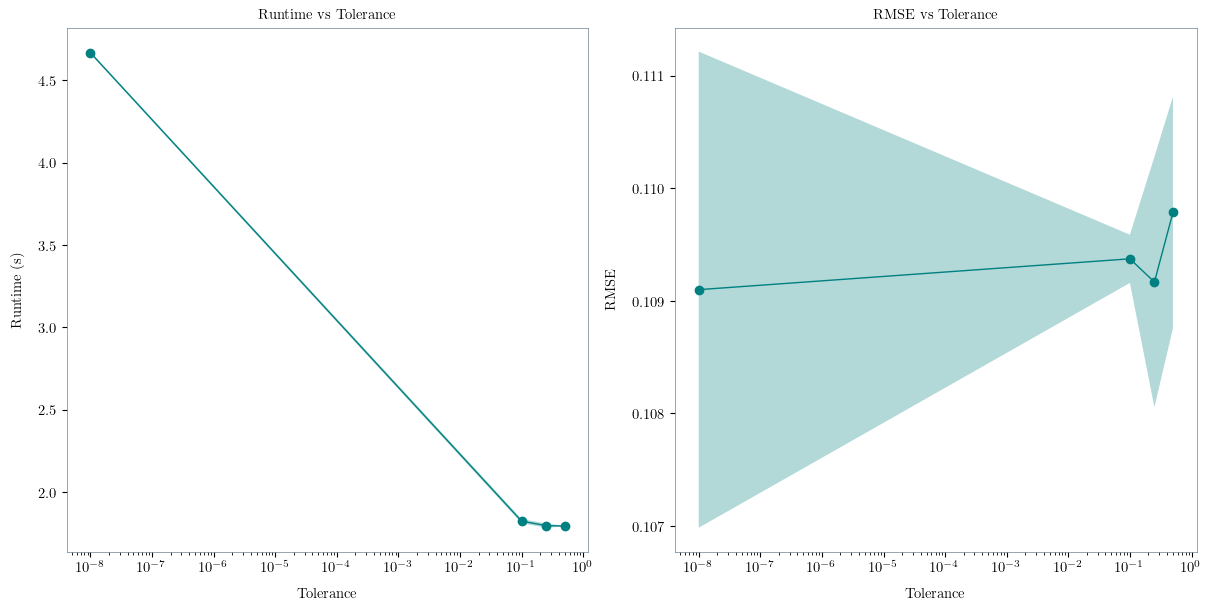

In [38]:
import matplotlib.pyplot as plt
from scripts.plot import *
plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)C

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Plot runtime vs tolerance
axes[0].plot(tolerances, runtimes, marker="o")
axes[0].fill_between(tolerances, np.array(runtimes) - np.array(runtimes_std), np.array(runtimes) + np.array(runtimes_std), alpha=0.3)
axes[0].set_xscale("log")
axes[0].set_xlabel("Tolerance")
axes[0].set_ylabel("Runtime (s)")
axes[0].set_title("Runtime vs Tolerance")

# Plot RMSE vs tolerance
axes[1].plot(tolerances, rmses, marker="o")
axes[1].fill_between(tolerances, np.array(rmses) - np.array(rmses_std), np.array(rmses) + np.array(rmses_std), alpha=0.3)
axes[1].set_xscale("log")
axes[1].set_xlabel("Tolerance")
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE vs Tolerance")

plt.savefig(f"plots/tolerance_analysis_{dataset_name}.png")
plt.show()

## 4.2 Evaluate the performance for different feature extractors / dependence on embedding quality

In [39]:
experiment_name = "ablation_feature_space"
df = pd.read_csv(f"results/pls_ablation_feature_space.csv")

df.head()

,Unnamed: 0,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
0,0,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,20,0.265480,0.5387,1.869368,0.148613,0.734027,1.213016,configs/FGMRES.json
1,1,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,20,0.255580,0.5696,1.730236,0.143934,0.710097,0.421592,configs/FGMRES.json
2,2,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,20,0.267524,0.4171,1.902345,0.152584,0.753066,0.414500,configs/FGMRES.json
3,3,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,20,0.263996,0.4137,1.849562,0.150010,0.740827,0.416112,configs/FGMRES.json
4,4,CIFAR10-H,10000,CLIP+UMAP,20,prob_label,0.5,10,20,0.262180,0.6190,1.811080,0.146663,0.723769,0.414670,configs/FGMRES.json


In [40]:
# build one large table here with all the results
from IPython.display import Markdown
experiment = "evaluate_all_datasets"
dataset_name = "ANIMALS10"
datasets = ["ANIMALS10", "EMNIST", "CIFAR10", "CIFAR10-H", "TinyImageNet", "MTSD"]
header = ["Algorithm"] + ["Anim.10", "EMNIST-d.", "CIF.10", "CIF.10-H", "Tiny I.N.", "MTSD"]

na_placeholder = np.nan

budget = 0.1

rows = []

models = ["CLIP", "RESNET", "VIT"]
for model in models:
    for alpha in df["alpha"].unique():
        row = [model + ", $\\alpha$ = " + str(alpha)]
        for dataset_name in datasets:
            try:
                dim_red_tech = model + "+UMAP"
                n_samples = int(budget * df.query(f"dataset == '{dataset_name}'")["n_data"].values[0])
                row.append(df.query(f"dataset == '{dataset_name}' and dim_reduction_technique == '{dim_red_tech}' and alpha == {alpha} and n_samples == {n_samples}")["RMSE"].values[0])
            except:
                row.append(na_placeholder)
        rows.append(row)


# generate the table in latex format
table = pd.DataFrame(rows, columns = header)

# Find min values (excluding first column)
min_vals = table.iloc[:, 1:].min()

# Formatter function to format numbers and highlight the minimum
def format_value(x, col):
    if col == header[0]:  # First column, no formatting
        return str(x)
    return f"\\textbf{{{x:.3f}}}" if x == min_vals[col] else f"{x:.3f}"

# Apply formatting
table_formatted = table.apply(lambda col: col.apply(lambda x: format_value(x, col.name)))

# # Generate LaTeX code with tabularx
latex_code = table_formatted.to_latex(
    index=False, escape=False
).replace(
    "\\begin{tabular}", f"\\begin{{tabularx}}{{\\linewidth}}"
).replace(
    "\\end{tabular}", f"\\end{{tabularx}}"
).replace(
    "{" + "l" * len(header) + "}", "{l" + "r" * (len(header) - 1) + "}" # column alignment # "X"
)


# Add LaTeX float specifier, caption, and label
latex_code = (
    "\\begin{table}[!ht]\n\\centering\n"
    + f"\\caption{{RMSE for different datasets and algorithms with {int(100*budget)}\\,\\% budget}}\n"
    + f"\\label{{tab:RMSE_all_datasets_{int(100*budget)}_percent}}\n"
    + latex_code
    + "\\end{table}"
)

# Add multirow and multicolumn manually
header_tex = (
    "\\multirow{2}{*}{\\textbf{Algorithms}} & \\multicolumn{"
    + f"{len(header)-1}"
    + "}{c}{\\textbf{Datasets}} \\\\\n"
    + f"\\cmidrule(lr){{2-{len(header)}}}\n"
    + "& " + " & ".join(header[1:]) + " \\\\"
)

# Replace the first header row
latex_code = latex_code.replace("\\toprule\n" + " & ".join(header) + " \\\\", "\\toprule\n" + header_tex)


# Display in Markdown
from IPython.display import Markdown
Markdown(f"```latex\n{latex_code}\n```")

```latex
\begin{table}[!ht]
\centering
\caption{RMSE for different datasets and algorithms with 10\,\% budget}
\label{tab:RMSE_all_datasets_10_percent}
\begin{tabularx}{\linewidth}{lrrrrrr}
\toprule
\multirow{2}{*}{\textbf{Algorithms}} & \multicolumn{6}{c}{\textbf{Datasets}} \\
\cmidrule(lr){2-7}
& Anim.10 & EMNIST-d. & CIF.10 & CIF.10-H & Tiny I.N. & MTSD \\
\midrule
CLIP, $\alpha$ = 0.5 & 0.071 & 0.061 & 0.115 & 0.121 & 0.048 & 0.192 \\
CLIP, $\alpha$ = 0.9 & 0.065 & 0.057 & 0.106 & \textbf{0.109} & 0.043 & 0.122 \\
CLIP, $\alpha$ = 0.99 & \textbf{0.064} & 0.059 & 0.111 & 0.114 & 0.045 & 0.088 \\
RESNET, $\alpha$ = 0.5 & 0.077 & 0.079 & 0.118 & 0.129 & 0.042 & 0.192 \\
RESNET, $\alpha$ = 0.9 & 0.069 & 0.074 & 0.109 & 0.117 & 0.037 & 0.121 \\
RESNET, $\alpha$ = 0.99 & 0.066 & 0.079 & 0.113 & 0.123 & 0.039 & 0.089 \\
VIT, $\alpha$ = 0.5 & 0.090 & 0.060 & 0.113 & 0.122 & 0.041 & 0.190 \\
VIT, $\alpha$ = 0.9 & 0.085 & \textbf{0.056} & \textbf{0.104} & 0.109 & \textbf{0.036} & 0.119 \\
VIT, $\alpha$ = 0.99 & 0.086 & 0.058 & 0.107 & 0.112 & 0.036 & \textbf{0.087} \\
\bottomrule
\end{tabularx}
\end{table}
```

In [41]:
end_time = time.time()
elapsed_time = end_time - start_time

hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Format the output
formatted_time = f"{int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds"
print(f"Script runtime: {formatted_time}")

Script runtime: 0 hours, 0 minutes, and 9.24 seconds
